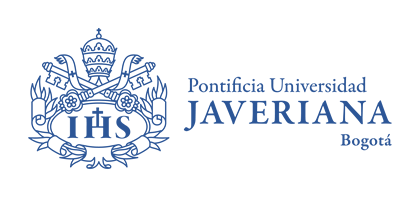

# Machine Learning - Workshop 2 Feed-forward neural networks
In this notebook, we will explore the use of feed-forward neural networks using Python. We will use the [keras](https://keras.io/) and tensorflow libraries.

## Setup

We will import the necesary libraries for this exercise

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Case Study - Conting fingers


In this case study, we will use a dataset of hand pictures to build a model that will try to count the number of fingers the hand is holding up.



### Aknowledgement
This dataset is available in kaggle
https://www.kaggle.com/koryakinp/fingers

The data preparation step is taken from this notebook: https://www.kaggle.com/databeru/can-a-neural-network-learn-to-count-fingers-99
Author: datalira at kaggle

## Problem statement

Understanding hand gestures is important for different artificial intelligence tasks. In particular those related with interacting with Human Computer interaction such as recognizing hand gestures for deaf people, sign language recognition, automatic sign recognition in sports or other human activities, among others.

In this excercise, we will approach a solution to a subproblem of hand gesture recognition. In this problem a neural network will recognize from a photo of a hand how many fingers the hand is holding up. The instance feature are the pixels of the image and the target variable is the number of fingers the hand in the photo is holding up.


## Data understanding and preparation

First, we will upload the images to google colab, in the files tab in the left, upload fingers.zip

**Important**

Let the upload process to finish before excecuting the rest of the notebook



In [ ]:
!ls -lh /content/

In [ ]:
if not os.path.exists('/content/fingers.zip'):
  raise Exception("File not uploades")
else :
  print("File fingers.zip found")

In [ ]:
size = os.path.getsize('/content/fingers.zip')
print(size)
if size< 189813513:
  raise Exception("File not complete!!, do not proceed!!")
else:
  print("File is complete, proceed ;)")

In [ ]:
# Unzip files in directory tain and test
!unzip -qq -o fingers.zip

In [ ]:
# content of train, first files
!ls /content/train | head

### Dataset creation
In the following lines we will create a dataframe to reference the images in both train and test datasets

In [ ]:
# Load the paths of the images
trainpaths = os.listdir("/content/train")
testpaths = os.listdir("/content/test")

# Add the all path to the paths of the images
train_str = "/content/train/"
trainpaths = ["/content/train/" + p for p in trainpaths]

test_str = "/content/test/"
testpaths = ["/content//test/" + p for p in testpaths]

# Create a DataFrame with the paths
df_train = pd.DataFrame(trainpaths, columns=['Filepath'])
df_train['set'] = 'train'

df_test = pd.DataFrame(testpaths, columns=['Filepath'])
df_test['set'] = 'test'

image_df = pd.concat([df_train,df_test])
image_df.reset_index(drop = True, inplace = True)

# Display the first rows
image_df.head(5)

In [ ]:
image_df

The label is encoded in each namefile, is the number at the end.

In [ ]:
# The first image is a 2
image_df.loc[0]['Filepath']

In [ ]:
# Create the labels (number of fingers)
image_df['label'] = image_df['Filepath'].apply(lambda x: x[-6])

In [ ]:
image_df['label']

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
sample_df=image_df.sample(len(axes.flat))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(sample_df.Filepath.iloc[i]))
    ax.set_title(sample_df.label.iloc[i])
plt.tight_layout()
plt.show()

In [ ]:
# Split the image_df in the training DataFrame and into the testing DataFrame
train_df = image_df[image_df['set'] == 'train']
test_df = image_df[image_df['set'] == 'test']

In [ ]:
train_df.shape

## Loading the images into the training and test dataset

We will use a technique in computer vision called data augmentation.

The idea is to perturb the images of the training set in order to create more images in the training set. We will create new images rotating, zooming in and shifting the images present in the original dataset.

In [ ]:
# This function will return 3 datasets: train, validation and test.
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='label',
        target_size=(224, 224),
        color_mode='rgb',
        label_mode='categorical',
        #batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        # Data augmentation parameters
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='label',
        target_size=(224, 224),
        color_mode='rgb',
        label_mode='categorical',
        #batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        #rotation_range=30, # Uncomment to use data augmentation
        #zoom_range=0.15,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.15,
        #horizontal_flip=True,
        #fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='label',
        target_size=(224, 224),
        color_mode='rgb',
        label_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
train_generator,test_generator,train_images,val_images,test_images = create_gen()

In [ ]:
examples=[]
for idx, i in enumerate(train_images):
  examples.append(i)
  if idx==0:
    break

In [ ]:
examples[0][0].shape

In [ ]:
examples[0][1]

In [ ]:
# Example of images in training set
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
sample=(examples[0][0])[0:len(axes.flat),:,:,:]
for i, ax in enumerate(axes.flat):
    ax.imshow(sample[i].astype(int))

plt.tight_layout()
plt.show()

In [ ]:
# first image
sample[0].astype(int)

In [ ]:
# first image (224x224 pixels X 3 channels (rgb))
sample[0].shape

## Model evaluation

Keras and tensorflow are libraries that enable the fast development of models for deep learning models.

The Sequential class ([documentation](https://keras.io/api/models/sequential/)) allows us to define an empty feedforward model and build upon it

In [ ]:
model=tf.keras.Sequential()

In the [layers](https://keras.io/api/layers/) module there are many types of layers we can use to construct our netwrok. For building a feedforward network we will use [Dense](https://keras.io/api/layers/core_layers/dense/) layers

Dense layers must receive the number of neuron units in the layer. Other important parameters to configure are the following


*   activation: The type of activation function in the layer
*   input_shape: When adding the first layer, we must submit the shape of each instance that is going to be connected to the network. We a receiving an image of three channels and we will convert it to a single vector using the flatten layer.


In [ ]:
model.add(tf.keras.layers.Flatten(input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Dense(64, activation='relu'))

The last layer is the output layer, since we have 6 possible answers (0 to 5 fingers up), we create 6 units. The activation of this final layer is the softmax activation function, which is used to normalize the output of the neural network so that the output of each neuron unit in the last layer sums up to one, representing a probability of each class.

In [ ]:
model.add(tf.keras.layers.Dense(6, activation='softmax'))

Once the architecture is defined, we have to compile the model.

The compilation process sets the optimization algorithm is going to be used to minimize the error and the parameters of the algorithm such as the learning rate. The compilation process will also set the error function that is going to be used to train the network. Finally, we can also configure  a number of metrics that we want to monitor during the optimization process.

*   You can check the optimization algorithms available in keras [here](https://keras.io/api/optimizers/#available-optimizers)

*   You can check the available loss functions in keras [here](https://keras.io/api/losses/)

* More about keras metrics [here](https://keras.io/api/metrics/).

For ths example, we will use the Adam optimization algorithm with a learning rate of 0.1 , and optimize the categorical cross_entropy loss. We will monitor during the process the categorical accuracy of the model.





In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

Once compiled, we can print a summary of the model's architecture

In [ ]:
model.summary()

The fit method starts the adjustment of the weights in the network. At the end of each epoch the network will evaluate the metric on the validation dataset

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
        )
    ]
)

Lets plot the training loss and the validation loss at the end of each epoch.

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training error')
plt.plot(epochs, val_loss, 'g', label='Validation error')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('categorical crossentropy')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(test_images)
print(results)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
y_test = list(test_df.label.astype(int))
print(classification_report(y_test, pred))

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## Workshop exercise 1

In the next cells, create a bigger model and analyze its performance. Increase the capacity of the model.  Add more intermediate hidden layers and check the loss and accuracy on the validation dataset.

## Transfer learning - Reusing models

It is difficult for a feedforward network to perform adequately on a computer vision dataset, particularly with only the information of that dataset.

Neural networks researchers and practitioners often reuse other networks from other models. In this case we will reuse a small neural network that has been trained on the [ImageNet](https://www.image-net.org/about.php) dataset for classification tasks.

This network will reduce the dimensionality of the input images to a vector that we can use to train our task. Since the pretrained model has seen many more images and more diverse images, it will make a better job summarizing each image into a vector than our previous attempts.

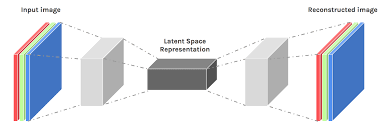



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
# We are not going to update the weights of the pretrained model
pretrained_model.trainable = False

In [ ]:
model_2=tf.keras.Sequential()
model_2.add(pretrained_model)
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dense(6, activation='softmax'))
model_2.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_2.summary()

In [ ]:
history_2 = model_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
        )
    ]
)

In [ ]:
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training error')
plt.plot(epochs, val_loss, 'g', label='Validation error')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('categorical crossentropy')
plt.legend()

plt.show()

In [ ]:
results = model_2.evaluate(test_images)
print(results)

In [ ]:
# Predict the label of the test_images
pred = model_2.predict(test_images)
pred = np.argmax(pred,axis=1)
y_test = list(test_df.label.astype(int))
print(classification_report(y_test, pred))

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## Regularization

Regularization is a technique in machine learning that helps models to avoid overspecialization.

### L1 and L2 regularizations

Regularization imposes a constraint into the loss function, penalizing the loss function by the magnitude of the weights of the network.

The l2 regularization imposes a penalty on the loss proportional to:

$ + \lambda \| \mathbf{w} \|_{L_{2}}$

Which takes into account the sum of the weights squared

The l1 regularization imposes a penalty on the loss proportional to:

$ + \lambda | \mathbf{w} |_{L_{1}}$

Which takes into account the sum of the absolute value of the weight

The $\lambda$ parameter is the regularization parameter. The largest the parameter, the largest the penalization, resulting in smaller weights and less complex models.

Increasing the regularization will increase the error on the training set, but could decrease the error on the validation and test sets.

One can regularize a leyer in TensorFlow by specifiying the parameter

``
  kernel_regularizer=tf.keras.regularizers.l1(0.01)
``

### Dropout layer

A dropout layer will randomly dissapear neurons during the training process with a probability given by parameter.
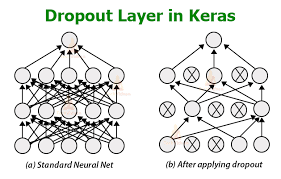

To use in a model this type of regularization, one can use a Dropout layer

``
model.add(tf.keras.layers.Dropout(0.2))
``


## Workshop exercise #2

Add regularization to the network.
Analyze the results of adding increasingly larger regularization constraints, via dropout or the l2 regularization. Compare the magnitude of the weights on a network.

Report on the best model found.